In [1]:
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

# Models and training tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import copy
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

from ConsistencyTesterFunctions import ANNModel, init_weights, find_best_Ridge, find_best_KNN, find_best_RF, find_best_ANN, find_best_logistic

# Statistics tools
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
import statsmodels.formula.api as smf
from itertools import combinations

In [2]:
HR_data = pd.read_csv('HR_data.csv')
HR_data.head()
scaler = StandardScaler()
inputcols = ['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC']

Create folds

In [4]:
unique_combinations = HR_data[['Cohort', 'Round']].drop_duplicates().values

# Create folds (note that there are different individuals in different cohorts, so we do not have to account for individuals explicitly)
folds = []
for cohort, round_ in unique_combinations:
    test_mask = (HR_data['Cohort'] == cohort) & (HR_data['Round'] == round_)
    train_mask = ~((HR_data['Cohort'] == cohort) | (HR_data['Round'] == round_))
    
    test_data = HR_data[test_mask]
    train_data = HR_data[train_mask]
    
    folds.append((train_data, test_data))

Train the models on the first fold 10 times and save the errors

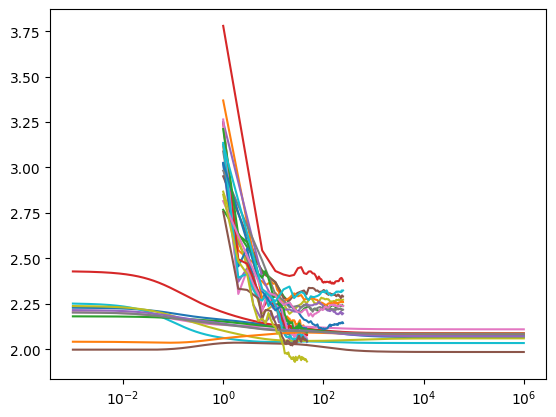

In [9]:
errors = {'Baseline':[], 'Ridge':[], 'KNN':[], 'RF':[], 'ANN':[], 'Logistic':[]}
par_data, val_data = folds[0]
for i in range(10):
    scaler.fit(par_data[inputcols])
    x_par = scaler.transform(par_data[inputcols])
    y_par = par_data['Frustrated']
    x_val = scaler.transform(val_data[inputcols])
    y_val = val_data['Frustrated']

    baseline = np.mean(y_par)
    baseline_errors = (y_val - baseline)**2
    errors['Baseline'].append(baseline_errors)

    ANN_model_params = find_best_ANN(x_par, y_par.values)
    model = ANNModel()
    model.load_state_dict(ANN_model_params)
    ANN_errors = ((model(torch.tensor(x_val).float())).detach().numpy()-y_val.values)**2
    errors['ANN'].append(ANN_errors)

    Ridge_hyperparams = find_best_Ridge(x_par, y_par.values)
    ridge_model = Ridge(alpha = Ridge_hyperparams)
    ridge_model.fit(x_par, y_par)
    ridge_errors = (ridge_model.predict(x_val)-y_val.values)**2
    errors['Ridge'].append(ridge_errors)

    KNN_hyperparams = int(find_best_KNN(x_par, y_par.values))
    KNN_model = KNeighborsRegressor(n_neighbors = KNN_hyperparams)
    KNN_model.fit(x_par, y_par)
    KNN_errors = (KNN_model.predict(x_val)-y_val.values)**2
    errors['KNN'].append(KNN_errors)

    RF_hyperparams = int(find_best_RF(x_par, y_par.values, np.random.randint(0, 2147483647)))
    RF_model = RandomForestRegressor(n_estimators = RF_hyperparams)
    RF_model.fit(x_par, y_par)
    RF_errors = (RF_model.predict(x_val)-y_val.values)**2
    errors['RF'].append(RF_errors)

    logistic_hyperparams = find_best_logistic(x_par, y_par.values)
    logistic_model = LogisticRegression(C=logistic_hyperparams, penalty='l2',max_iter = 10**6)
    logistic_model.fit(x_par, y_par)
    logistic_errors = (logistic_model.predict(x_val)-y_val.values)**2
    errors['Logistic'].append(logistic_errors)

Export data

In [14]:
import pickle

# Save to a file
with open('ConsistencyErrors.pkl', 'wb') as file:
    pickle.dump(errors, file)

Consistency metric: standard deviation of the mean error

In [28]:
for model in ['Baseline', 'Ridge', 'KNN', 'RF', 'ANN', 'Logistic']:
    print(model,":",sep="")
    print(np.std(np.array(errors[model]).mean(axis=1), ddof=1))

Baseline:
4.681111291435602e-16
Ridge:
0.048678369355566325
KNN:
0.12544283736863504
RF:
0.41340462146164225
ANN:
1.7273618952487906
Logistic:
0.18446619684315535
